In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from collections import Counter
from torch.optim import Adam
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

subset_indices = list(range(1280))
train_dataset = Subset(train_dataset, subset_indices)
test_dataset = Subset(test_dataset, subset_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.65MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
digit_counter = Counter()
for images, labels in train_loader:
    digit_counter.update(labels.numpy())
for digit, count in digit_counter.items():
    print(f"Digit {digit}: {count}")

print('--------')

digit_counter = Counter()
for images, labels in test_loader:
    digit_counter.update(labels.numpy())
for digit, count in digit_counter.items():
    print(f"Digit {digit}: {count}")

Digit 5: 112
Digit 6: 118
Digit 2: 126
Digit 3: 119
Digit 9: 127
Digit 8: 115
Digit 1: 152
Digit 7: 150
Digit 0: 119
Digit 4: 142
--------
Digit 2: 126
Digit 9: 127
Digit 8: 115
Digit 3: 119
Digit 6: 118
Digit 7: 150
Digit 4: 142
Digit 0: 119
Digit 1: 152
Digit 5: 112


In [4]:
def debug_print(debug, message, tensor=None):
    if debug:
        if tensor is not None:
            print(f"{message}: {tensor.shape}")
        else:
            print(message)

def squash(input_tensor):
    squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
    output_tensor = (squared_norm / (1. + squared_norm)) *  (input_tensor / torch.sqrt(squared_norm))
    return output_tensor

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9, debug=False):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1)
        self.debug = debug

    def forward(self, x):
        x = self.conv(x)
        debug_print(self.debug, "x after conv", x)
        x = F.relu(x)
        debug_print(self.debug, "x after ReLU", x)
        return x


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, debug=False):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList()
        for _ in range(num_capsules):
            capsule = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            self.capsules.append(capsule)
        self.debug = debug
    
    def forward(self, x):
        stacked_capsules = [capsule(x) for capsule in self.capsules]
        if self.debug: 
            print("capsule_out:")
            for capsule_out in stacked_capsules:
                print("\t", capsule_out.shape)
        stacked_capsules = torch.stack(stacked_capsules, dim=1)
        debug_print(self.debug, "stacked_capsules", stacked_capsules)
        flattened_capsules = stacked_capsules.view(x.size(0), 32 * 6 * 6, -1)
        debug_print(self.debug, "flattened_capsules", flattened_capsules)
        squashed_output = squash(flattened_capsules)
        debug_print(self.debug, "squashed_output", squashed_output)
        return squashed_output


class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16, debug=False):
        super(DigitCaps, self).__init__()
        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))
        self.debug = debug

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)
        debug_print(self.debug, "x after stacking", x)

        W = torch.cat([self.W] * batch_size, dim=0)
        debug_print(self.debug, "W", W)
        
        u_hat = torch.matmul(W, x)
        debug_print(self.debug, "u_hat", u_hat)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        b_ij.to(device)
        debug_print(self.debug, "b_ij", b_ij)

        num_iter = 3
        for i in range(num_iter):
            if self.debug: print()
            c_ij = F.softmax(b_ij, dim=1)
            debug_print(self.debug, "c_ij", c_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)
            debug_print(self.debug, "c_ij after repeat", c_ij)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            debug_print(self.debug, "s_j", s_j)

            v_j = squash(s_j)
            debug_print(self.debug, "v_j", v_j)
            
            a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
            debug_print(self.debug, "a_ij", a_ij)
            b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)
            debug_print(self.debug, "b_ij updated", b_ij)

        return v_j.squeeze(1)

class Decoder(nn.Module):
    def __init__(self, debug=False):
        super(Decoder, self).__init__()
        self.debug = debug
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        debug_print(self.debug, "classes before softmax", classes)
        classes = F.softmax(classes, dim=0)
        debug_print(self.debug, "classes after softmax", classes)
        
        _, max_length_indices = classes.max(dim=1)
        debug_print(self.debug, "max_length_indices", max_length_indices)
        masked = Variable(torch.sparse.torch.eye(10))
        debug_print(self.debug, "masked", masked)
        masked = masked.to(device)
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        debug_print(self.debug, "masked after index_select", masked)
        
        return masked


In [5]:
class CapsuleNet(nn.Module):
    def __init__(self, debug=False):
        super(CapsuleNet, self).__init__()
        self.conv_layer = ConvLayer(debug=debug)
        self.primary_capsules = PrimaryCaps(debug=debug)
        self.digit_capsules = DigitCaps(debug=debug)
        self.decoder = Decoder(debug=debug)
        self.mse_loss = nn.MSELoss()
        self.debug = debug
        
    def forward(self, data):
        debug_print(self.debug, f"Input data", data)
        debug_print(self.debug, "\nCONV")
        output = self.conv_layer(data)
        debug_print(self.debug, "\nPRIMARY")
        output = self.primary_capsules(output)
        debug_print(self.debug, "\nDIGIT")
        output = self.digit_capsules(output)
        debug_print(self.debug, "\nDECODER")
        masked = self.decoder(output, data)
        debug_print(self.debug, "\nOUTPUT", output)
        return output, masked

    def loss(self, x, target):
        return self.margin_loss(x, target)
    
    def margin_loss(self, x, labels):
        batch_size = x.size(0)
        v_k = torch.sqrt((x**2).sum(dim=2, keepdim=True))
        left = F.relu(0.9 - v_k).view(batch_size, -1)
        right = F.relu(v_k - 0.1).view(batch_size, -1)
        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()
        return loss

In [6]:
capsule_net = CapsuleNet(debug=True).to(device) 
data, target = next(iter(train_loader))
target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
data, target = Variable(data), Variable(target)
data, target = data.to(device), target.to(device)
output, masked = capsule_net(data)

Input data: torch.Size([128, 1, 28, 28])

CONV
x after conv: torch.Size([128, 256, 20, 20])
x after ReLU: torch.Size([128, 256, 20, 20])

PRIMARY
capsule_out:
	 torch.Size([128, 32, 6, 6])
	 torch.Size([128, 32, 6, 6])
	 torch.Size([128, 32, 6, 6])
	 torch.Size([128, 32, 6, 6])
	 torch.Size([128, 32, 6, 6])
	 torch.Size([128, 32, 6, 6])
	 torch.Size([128, 32, 6, 6])
	 torch.Size([128, 32, 6, 6])
stacked_capsules: torch.Size([128, 8, 32, 6, 6])
flattened_capsules: torch.Size([128, 1152, 8])
squashed_output: torch.Size([128, 1152, 8])

DIGIT
x after stacking: torch.Size([128, 1152, 10, 8, 1])
W: torch.Size([128, 1152, 10, 16, 8])
u_hat: torch.Size([128, 1152, 10, 16, 1])
b_ij: torch.Size([1, 1152, 10, 1])

c_ij: torch.Size([1, 1152, 10, 1])
c_ij after repeat: torch.Size([128, 1152, 10, 1, 1])
s_j: torch.Size([128, 1, 10, 16, 1])
v_j: torch.Size([128, 1, 10, 16, 1])
a_ij: torch.Size([128, 1152, 10, 1, 1])
b_ij updated: torch.Size([1, 1152, 10, 1])

c_ij: torch.Size([1, 1152, 10, 1])
c_ij 

In [7]:
capsule_net = CapsuleNet().to(device) 
optimizer = Adam(capsule_net.parameters())

n_epochs = 20

for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for batch_id, (data, target) in enumerate(train_loader):
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, masked = capsule_net(data)
        loss = capsule_net.loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = np.argmax(masked.data.cpu().numpy(), axis=1)
        targets = np.argmax(target.data.cpu().numpy(), axis=1)
        correct_train += np.sum(preds == targets)
        total_train += len(targets)
    
    train_accuracy = correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_accuracy:.4f}")
    

Epoch 1/20 - Loss: 0.8215 - Accuracy: 0.5539
Epoch 2/20 - Loss: 0.7104 - Accuracy: 0.7516
Epoch 3/20 - Loss: 0.6299 - Accuracy: 0.8242
Epoch 4/20 - Loss: 0.5677 - Accuracy: 0.8594
Epoch 5/20 - Loss: 0.5165 - Accuracy: 0.8984
Epoch 6/20 - Loss: 0.4744 - Accuracy: 0.9195
Epoch 7/20 - Loss: 0.4398 - Accuracy: 0.9375
Epoch 8/20 - Loss: 0.4094 - Accuracy: 0.9461
Epoch 9/20 - Loss: 0.3836 - Accuracy: 0.9523
Epoch 10/20 - Loss: 0.3603 - Accuracy: 0.9602
Epoch 11/20 - Loss: 0.3403 - Accuracy: 0.9656
Epoch 12/20 - Loss: 0.3210 - Accuracy: 0.9656
Epoch 13/20 - Loss: 0.3028 - Accuracy: 0.9727
Epoch 14/20 - Loss: 0.2819 - Accuracy: 0.9742
Epoch 15/20 - Loss: 0.2606 - Accuracy: 0.9766
Epoch 16/20 - Loss: 0.2392 - Accuracy: 0.9797
Epoch 17/20 - Loss: 0.2196 - Accuracy: 0.9852
Epoch 18/20 - Loss: 0.2007 - Accuracy: 0.9836
Epoch 19/20 - Loss: 0.1811 - Accuracy: 0.9852
Epoch 20/20 - Loss: 0.1625 - Accuracy: 0.9883


In [8]:
capsule_net.eval()
test_loss = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data, target in test_loader:
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)

        output, masked = capsule_net(data)
        loss = capsule_net.loss(output, target)
        test_loss += loss.item()

        preds = np.argmax(masked.data.cpu().numpy(), axis=1)
        targets = np.argmax(target.data.cpu().numpy(), axis=1)
        correct_test += np.sum(preds == targets)
        total_test += len(targets)

test_accuracy = correct_test / total_test
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1474 - Test Accuracy: 0.9875


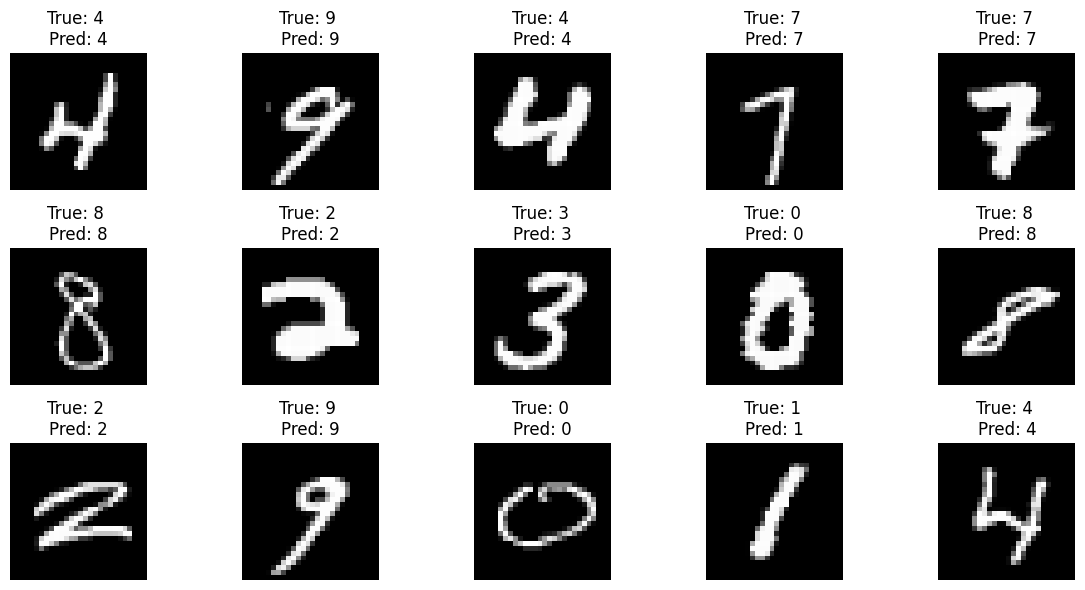

In [9]:
capsule_net.eval()

with torch.no_grad():
    data, target = next(iter(test_loader))
    target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
    data, target = Variable(data), Variable(target)
    data, target = data.to(device), target.to(device)
    output, masked = capsule_net(data)
    preds = np.argmax(masked.data.cpu().numpy(), axis=1)
    targets = np.argmax(target.data.cpu().numpy(), axis=1)

    fig, axes = plt.subplots(3, 5, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(15):
        ax = axes[i]
        ax.imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f"True: {targets[i]} \nPred: {preds[i]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()